## Load Data and libraries

In [2]:
import scipy.stats as stats
import pickle
from dotmap import DotMap
import seaborn as sns
import sys
import matplotlib.pyplot as plt
import pandas as pd
import os
from pathlib import Path
sys.path.append(str(Path(os.getcwd()).parent))

PPMI_BIOSPECIMEN_GEN_DATA_DIR_INSIDE = Path(os.getcwd()).parent 
PPMI_BIOSPECIMEN_GEN_DATA_DIR_INSIDE = PPMI_BIOSPECIMEN_GEN_DATA_DIR_INSIDE / 'generated_data/biospecimen/ppmi'
with open(PPMI_BIOSPECIMEN_GEN_DATA_DIR_INSIDE / 'preprocessed/jul1022/paper_experiment_flip_outlier.pkl', 'rb') as f:
    data_biospecimen = pickle.load(f)

In [3]:
sns.set(context='notebook', style='ticks', font_scale=1.6, font='sans-serif', rc={"lines.linewidth": 1.2})
sns.set_style("white")
sns.set_style("ticks", {"xtick.major.size": 8, "ytick.major.size": 8})

In [4]:
M_chosen = data_biospecimen['half']['M_cleaned'].copy()

In [5]:
M_chosen.columns = M_chosen.columns.get_level_values(1)

In [6]:
d_gmm = {'HC': 0, 'PD_l': 1, 'PD_m': 2, 'PD_h': 3}

In [7]:
M_chosen['GMM'] = M_chosen['GMM'].map(lambda x: d_gmm[x])

In [8]:
import numpy as np
corr = np.abs(M_chosen.corr())
mask = np.triu(np.ones_like(corr, dtype=np.bool))

/var/folders/y5/tr1yp82s2ns2_4g_6flxk45jrqb07t/T/ipykernel_22195/3425683158.py:3: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.triu(np.ones_like(corr, dtype=np.bool))


<AxesSubplot:xlabel='feature', ylabel='feature'>

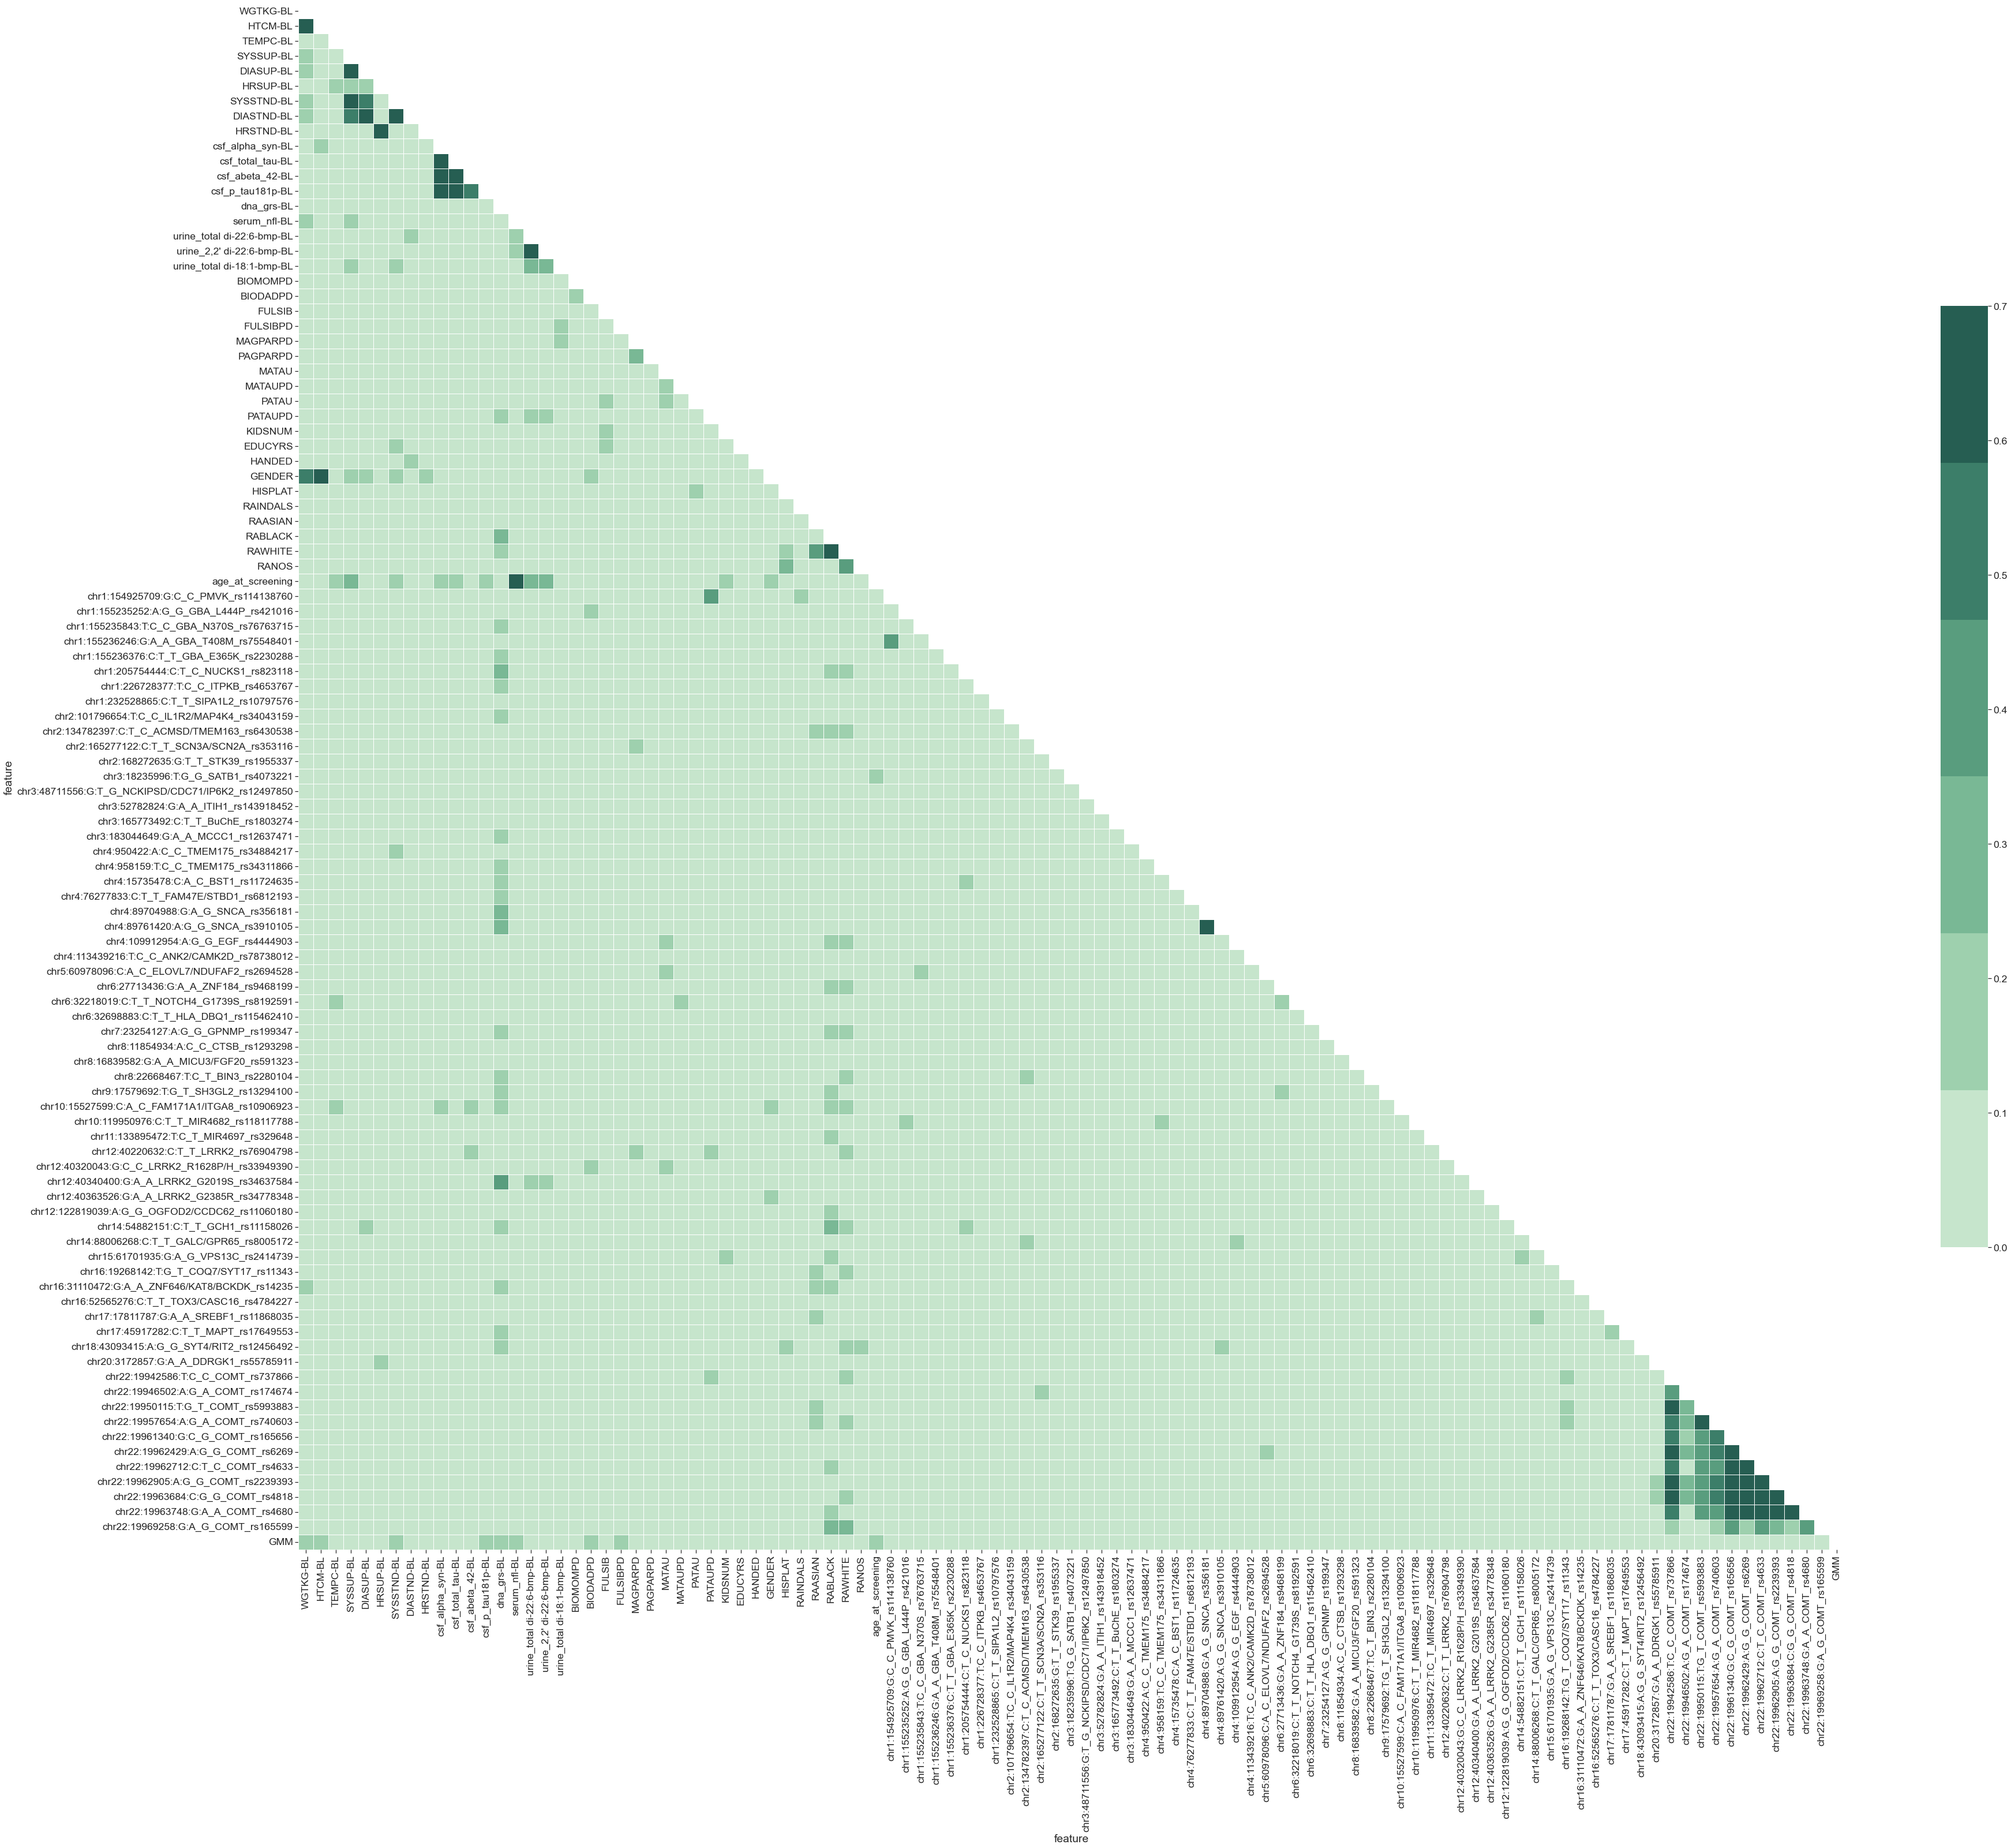

In [9]:
# M_chosen.columns = M_chosen.columns.get_level_values(1)
# import numpy as np
# corr = np.abs(M_chosen.corr())
# mask = np.triu(np.ones_like(corr, dtype=np.bool))
f, ax = plt.subplots(figsize=(60, 60))
cmap = sns.color_palette("ch:2.5,-.2,dark=.3")
sns.heatmap(corr, mask=mask, cmap=cmap, vmin=0, vmax=0.7, square=True, linewidths=.5, cbar_kws={"shrink": .5})
# plt.savefig('images/correlation_genetics_biospecimen.pdf', dpi=60)

In [10]:
Labels = pd.DataFrame(data_biospecimen['half']['Labels'], columns=['GMM'])
dname = "half"
cnt_subtype = dict(zip(list(Labels['GMM'].value_counts().index), list(Labels['GMM'].value_counts())))

In [11]:
feats_involving_time = data_biospecimen[dname]['feats_involving_time']
feats_not_involving_time = data_biospecimen[dname]['feats_not_involving_time']
temp = {}
for feat in feats_not_involving_time:
    # print (feat)
    temp[feat] = pd.merge(data_biospecimen[dname]['data'][feat], Labels, left_index=True, right_index=True)
dna_grs = pd.merge(data_biospecimen[dname]['data']['dna_grs'], Labels, left_index=True, right_index=True).reset_index().set_index('PATNO')
del dna_grs['EVENT_ID']
del dna_grs['TYPE']
del dna_grs['TESTNAME']
dna_grs.columns = ['dna_grs', 'GMM']
temp['dna_grs'] = dna_grs
features_include = [
    ('screening', 'age_at_screening', 'continuous', 'f_oneway', None),
    ('socio', 'EDUCYRS', 'continuous', 'f_oneway', None),
    ('screening', 'GENDER', 'categorical', 'chi_square', {0: 'Female', 1: 'Female', 2: 'Male'}),
    ('socio', 'HANDED', 'categorical', 'chi_square', {3: 'LEFT', 1: 'RIGHT', 2: 'NA'}),
    ('apoe_genetics', 'apoe_genetics', 'categorical', 'chi_square', None),
    ('dna_grs', 'dna_grs', 'continuous', 'f_oneway', None)
]
group_names = ['HC', 'PD_l', 'PD_m', 'PD_h']
header_list = ['p_value', 'valid', 'test_name', 'fname', 'dtype', 'feature']
group_dict = {}

## Create progression plots for biomarkers

In [12]:
biospecimen_truth = pd.DataFrame()
for feat in feats_involving_time[:1] + feats_involving_time[2:]:
    # print (feat)
    temp = data_biospecimen[dname]['data'][feat]
    temp2 = pd.merge(temp, Labels,left_index=True, right_index=True, how='inner').reset_index()
    temp3 = temp2.sort_values(by='EVENT_ID').replace({'SC':'BL'}).drop_duplicates(subset=['PATNO', 'EVENT_ID'], keep='first', inplace=False)
    temp4 = temp3[temp3['EVENT_ID'].isin(['BL', 'V04', 'V06', 'V08', 'V10', 'V12'])]
    temp5 = temp4.melt(id_vars=['GMM', 'PATNO', 'EVENT_ID'])
    if 'TYPE' in list(temp5['variable']):
        temp5 = temp5[temp5['variable']=='TESTVALUE']
        temp5 = temp5.replace({'TESTVALUE': feat})
    if len(set(temp5['EVENT_ID'])) <= 1:
        continue
    temp5 = temp5.set_index('PATNO')
    biospecimen_truth = pd.concat([biospecimen_truth, temp5], axis=0)


In [13]:
mapping_function = {}
palette_progression = {'PDvec3':'orange', 'PDvec2': 'blue', 'PDvec1':'green', 'Non-PD':'red'}

subtype_order = ['PDvec3', 'PDvec2', 'PDvec1', 'Non-PD']
dimension_replace = {'Sleep': 'Sleep dimension', 'Cognitive': 'Cognitive dimension', 'Motor': 'Motor dimension'}
subtype_replace = {'PD_h':'PDvec3', 'PD_m': 'PDvec2', 'PD_l':'PDvec1', 'HC':'Non-PD'}
latent_weight_replace = {'latent_weight1': 'Cognitive dimension', 'latent_weight2': 'Motor dimension', 
                        'latent_weight3': 'Sleep dimension'}
subtype_cname = {'GMM': 'Subtypes'}
cols_func = {"GMM": "Subtypes", "variable": "Feature", "value": "Value", 'EVENT_ID': 'Visit ID'}
# biospecimen_truth['variable'] = biospecimen_truth['variable'].map(lambda x: mapping_function.get(x, x))
biospecimen_truth = biospecimen_truth.replace(subtype_replace)
biospecimen_truth_new = biospecimen_truth.rename(columns=cols_func)
biospecimen_truth_new = biospecimen_truth_new[~biospecimen_truth_new['Feature'].isin(['dna_grs'])]
glist3 = list(biospecimen_truth_new.groupby('Feature'))

14it [00:02,  5.92it/s]


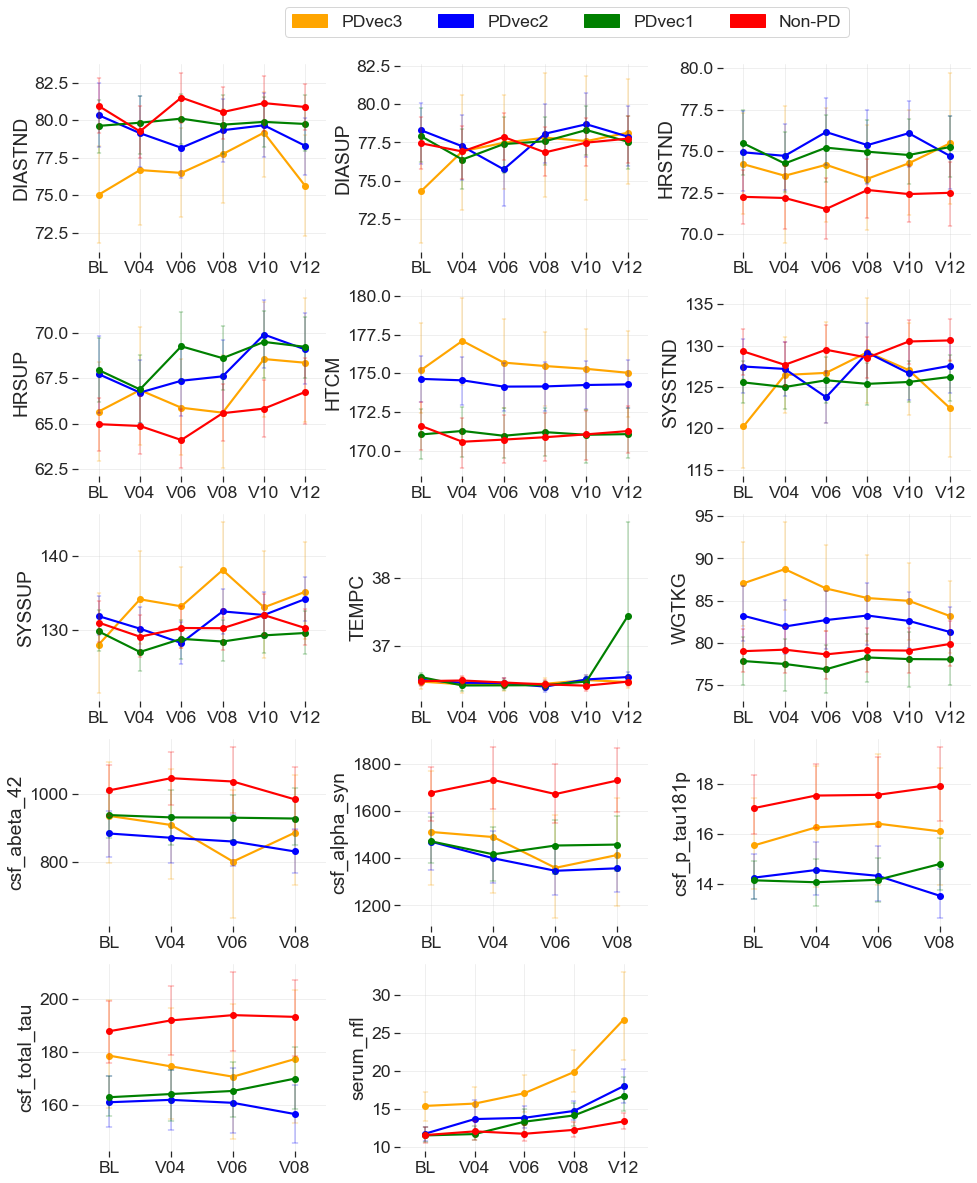

In [14]:
sns.set(context='notebook', style='ticks', font_scale=1.6, font='sans-serif', rc={"lines.linewidth": 1.2})
sns.set_style("white")
sns.set_style("ticks", {"xtick.major.size": 8, "ytick.major.size": 8})
columns = ['PD_h', 'PD_m', 'PD_l', 'HC']

fig, axs = plt.subplots(5, 3, figsize=[16, 20])
plt.subplots_adjust(wspace=0.3, hspace=0.2)
fig.delaxes(axs[4][2])
axslist = axs.reshape(-1)

from tqdm import tqdm
import matplotlib.patches as mpatches
color_patch = []
for lab, color in palette_progression.items():
    color_patch.append(mpatches.Patch(color=color, label=lab))
for e, k in tqdm(enumerate(range(len(glist3)))):
    temp = glist3[k][1]
    sns.pointplot(x="Visit ID", y="Value", hue="Subtypes", col="Feature",
                         data=temp.sort_values(by=['Visit ID', "Value"]),
                         hue_order=subtype_order, sharex=True, 
                         sharey=True, palette=palette_progression, legend_out=False, errwidth=0.4, capsize=0.1, ax=axslist[e])
    axslist[e].set_xlabel('')
    axslist[e].set_ylabel(glist3[k][0])
    # labels = [item.get_text() for item in axslist[e].get_yticklabels()]
    # axslist[e].set_yticklabels([str(round(float(label), 0)) for label in labels])
    # break
    axslist[e].spines['left'].set_visible(False)    
    axslist[e].spines['top'].set_visible(False)
    axslist[e].spines['right'].set_visible(False)
    axslist[e].spines['bottom'].set_visible(False)
    axslist[e].grid(True, alpha=0.3)
    if e==0:
        axslist[e].legend(handles=color_patch, bbox_to_anchor=(0.8, 1.1), loc='lower left', ncol=4, numpoints=1 )
    else:
        axslist[e].legend_.remove()
        # locs, labels = yticks()
    # if e >= 5:
    #    break
# axslist[-1].remove()
# plt.savefig('images/progression_plot_biomarkers.png', dpi=100, bbox_inches='tight')
# plt.savefig('images/progression_plot_biomarkers_full_document.pdf', dpi=80, bbox_inches='tight')

14it [00:00, 29.91it/s]
/Users/dadua2/anaconda3/envs/py38/lib/python3.8/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 8208 (\N{HYPHEN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


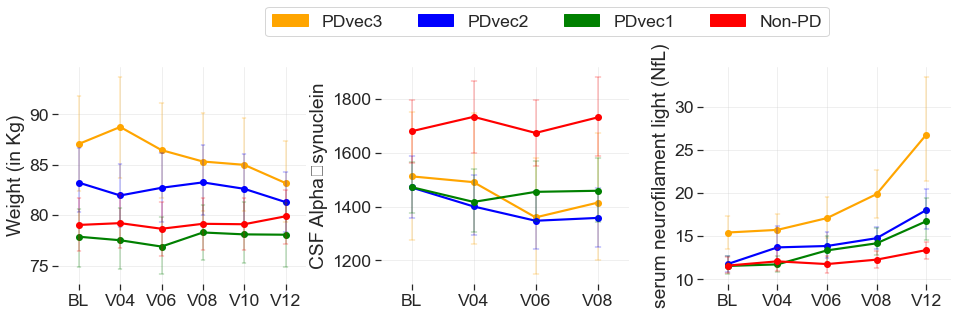

In [15]:
sns.set(context='notebook', style='ticks', font_scale=1.6, font='sans-serif', rc={"lines.linewidth": 1.2})
sns.set_style("white")
sns.set_style("ticks", {"xtick.major.size": 8, "ytick.major.size": 8})
columns = ['PD_h', 'PD_m', 'PD_l', 'HC']

fig, axs = plt.subplots(1, 3, figsize=[16, 4])
plt.subplots_adjust(wspace=0.3, hspace=0.2)
# fig.delaxes(axs[4][2])
axslist = axs.reshape(-1)
feature_to_look = {'serum_nfl': 'serum neurofilament light (NfL)', 'WGTKG': 'Weight (in Kg)', 'csf_alpha_syn': 'CSF Alpha‐synuclein'}

from tqdm import tqdm
import matplotlib.patches as mpatches
color_patch = []
for lab, color in palette_progression.items():
    color_patch.append(mpatches.Patch(color=color, label=lab))
e = 0
for enm, k in tqdm(enumerate(range(len(glist3)))):
    if not glist3[k][0] in feature_to_look:
        continue
    temp = glist3[k][1]
    sns.pointplot(x="Visit ID", y="Value", hue="Subtypes", col="Feature",
                         data=temp.sort_values(by=['Visit ID', "Value"]),
                         hue_order=subtype_order, sharex=True, 
                         sharey=True, palette=palette_progression, legend_out=False, errwidth=0.4, capsize=0.1, ax=axslist[e])
    axslist[e].set_xlabel('')
    axslist[e].set_ylabel(feature_to_look[glist3[k][0]])
    # labels = [item.get_text() for item in axslist[e].get_yticklabels()]
    # axslist[e].set_yticklabels([str(round(float(label), 0)) for label in labels])
    # break
    axslist[e].spines['left'].set_visible(False)    
    axslist[e].spines['top'].set_visible(False)
    axslist[e].spines['right'].set_visible(False)
    axslist[e].spines['bottom'].set_visible(False)
    axslist[e].grid(True, alpha=0.3)
    if e==0:
        axslist[e].legend(handles=color_patch, bbox_to_anchor=(0.8, 1.1), loc='lower left', ncol=4, numpoints=1 )
    else:
        axslist[e].legend_.remove()
    e += 1
        # locs, labels = yticks()
    # if e >= 5:
    #    break
# axslist[-1].remove()
# plt.savefig('slides/progression_plot_biomarkers.png', dpi=200, bbox_inches='tight')
# plt.savefig('images/progression_plot_biomarkers_full_document.pdf', dpi=80, bbox_inches='tight')